# Window examples

In this notebook we will show how to compute the window function associated with a survey geometry, and build the corresponding window convolution (and wide-angle) matrix in Fourier space to convolve the theory power spectrum with, following https://arxiv.org/abs/2106.06324. Look first at notebook basic_examples.ipynb to understand the *pypower* API.

In [1]:
import os
import tempfile

import numpy as np
import fitsio
from matplotlib import pyplot as plt

from pypower import CatalogFFTPower, CatalogFFTWindowMultipole, PowerSpectrumWindowMultipole,\
                    BaseMatrix, PowerSpectrumWindowMultipoleMatrix, PowerSpectrumOddWideAngleMatrix,\
                    mpi, setup_logging

# To activate logging
setup_logging()

# Input mock (1 Gpc/$h$ wide)

In [2]:
base_dir = os.path.join('..', 'pypower', 'tests', 'catalog')
data_fn = os.path.join(base_dir, 'lognormal_data.fits')
randoms_fn = os.path.join(base_dir, 'lognormal_randoms.fits')

# Read input catalogs, scattering on all MPI ranks (1 in this notebook)
def read(fn, columns=('Position', 'WEIGHT_FKP'), ext=1, mpicomm=mpi.COMM_WORLD):
    gsize = fitsio.FITS(fn)[ext].get_nrows()
    start, stop = mpicomm.rank * gsize // mpicomm.size, (mpicomm.rank + 1) * gsize // mpicomm.size
    tmp = fitsio.read(fn, ext=ext, columns=columns, rows=range(start, stop))
    return [tmp[col] for col in columns]

data_positions, data_weights = read(data_fn)
randoms_positions, randoms_weights = read(randoms_fn)

boxcenter = np.array([500.,0.,0.])[None,:]
for positions in [data_positions, randoms_positions]:
    positions += boxcenter

# Power spectrum estimation

[000000.52]  01-16 17:01  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[1199.99914551 1199.99914551 1199.99914551], boxcenter=[ 5.00000092e+02 -2.13623047e-04  6.25610352e-04], dtype=float32).
[000001.13]  01-16 17:01  CatalogMesh                  INFO     Running interlacing at order 2.
[000001.78]  01-16 17:01  CatalogFFTPower              INFO     Done painting catalog 1 to mesh.
[000001.79]  01-16 17:01  CatalogFFTPower              INFO     Using 40 k-bins between 0.000 and 0.200.
[000002.73]  01-16 17:01  CatalogFFTPower              INFO     Running power spectrum estimation.
[000003.07]  01-16 17:01  CatalogFFTPower              INFO     ell = 0 done; 1 r2c completed
[000003.52]  01-16 17:01  numexpr.utils                INFO     NumExpr defaulting to 4 threads.
[000004.50]  01-16 17:01  CatalogFFTPower              INFO     ell = 2 done; 5 r2c completed
[000005.37]  01-16 17:01  CatalogFFTPower              INFO     

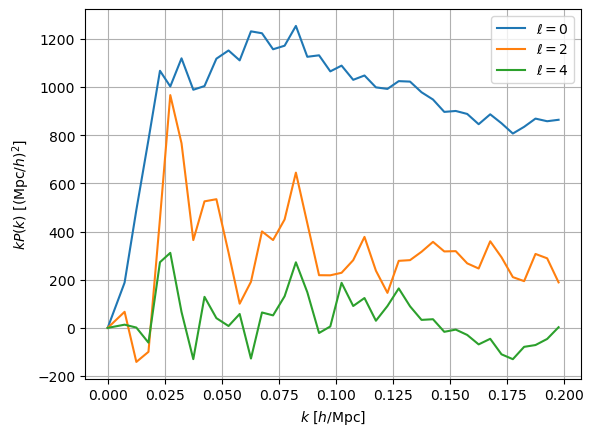

In [3]:
kedges = np.linspace(0, 0.2, 41)
poles = CatalogFFTPower(data_positions1=data_positions, data_weights1=data_weights, randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                        nmesh=128, resampler='tsc', interlacing=2, ells=(0, 2, 4), los='firstpoint', edges=kedges, position_type='pos', dtype='f4').poles
print('Shot noise is {:.4f}.'.format(poles.shotnoise))
print('Normalization is {:.4f}.'.format(poles.wnorm))
ax = plt.gca()
for ill, ell in enumerate(poles.ells):
    ax.plot(poles.k, poles.k * poles(ell=ell, complex=False), label='$\ell = {:d}$'.format(ell))
ax.legend()
ax.grid(True)
ax.set_xlabel('$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

# (Approximate) window function estimation

[000006.57]  01-16 17:01  CatalogFFTWindowMultipole    INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[8000. 8000. 8000.], boxcenter=[ 5.00000092e+02 -2.13623047e-04  6.25610352e-04], dtype=float32).
[000006.97]  01-16 17:01  CatalogMesh                  INFO     Running interlacing at order 2.
[000007.49]  01-16 17:01  CatalogFFTWindowMultipole    INFO     Done painting catalog 1 to mesh.
[000007.49]  01-16 17:01  CatalogFFTWindowMultipole    INFO     Using 50 k-bins between 0.000 and 0.050.
[000007.63]  01-16 17:01  CatalogFFTWindowMultipole    INFO     Running power spectrum estimation.
[000007.92]  01-16 17:01  CatalogFFTWindowMultipole    INFO     ell = 0 done; 1 r2c completed
[000010.72]  01-16 17:01  CatalogFFTWindowMultipole    INFO     ell = 2 done; 5 r2c completed
[000011.60]  01-16 17:01  CatalogFFTWindowMultipole    INFO     ell = 4 done; 9 r2c completed
[000013.03]  01-16 17:01  CatalogFFTWindowMultipole    INFO     ell = 6 done; 13 r2c comple

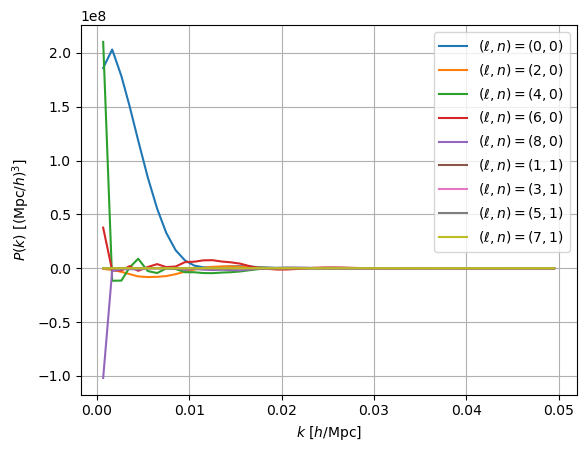

In [4]:
# Let us compute the window function multipoles in k-space
edges = {'step':0.001}
window1 = CatalogFFTWindowMultipole(randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                   power_ref=poles, edges=edges, boxsize=8000., position_type='pos', dtype='f4').poles
# You can save the window function
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    window1.save(fn)
    window = PowerSpectrumWindowMultipole.load(fn)
    print(window.projs)

ax = plt.gca()
for iproj, proj in enumerate(window.projs):
    ax.plot(window.k, window(proj=proj, complex=False), label=proj.latex(inline=True))
ax.legend(loc=1)
ax.grid(True)
ax.set_xlabel('$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()

## Concatenating windows

One can try to increase accuracy on small scales, by reducing the box size (still encompassing the whole catalog),
keeping mesh size the same, i.e. increasing the Nyquist frequency...

WARNING: This is just an example to show how to "concatenate" window multipoles, maybe not something one should do; at least that should be tested.

It seems though that this is what is done by Florian's code, using box sizes [5000, 10000, 100000].

[000028.48]  01-16 17:02  CatalogFFTWindowMultipole    INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[128 128 128], boxsize=[1000. 1000. 1000.], boxcenter=[ 5.00000092e+02 -2.13623047e-04  6.25610352e-04], dtype=float32).
[000028.93]  01-16 17:02  CatalogMesh                  INFO     Running interlacing at order 2.
[000029.47]  01-16 17:02  CatalogFFTWindowMultipole    INFO     Done painting catalog 1 to mesh.
[000029.47]  01-16 17:02  CatalogFFTWindowMultipole    INFO     Using 402 k-bins between 0.000 and 0.402.
[000029.59]  01-16 17:02  CatalogFFTWindowMultipole    INFO     Running power spectrum estimation.
[000029.84]  01-16 17:02  CatalogFFTWindowMultipole    INFO     ell = 0 done; 1 r2c completed
[000032.53]  01-16 17:02  CatalogFFTWindowMultipole    INFO     ell = 2 done; 5 r2c completed
[000033.35]  01-16 17:02  CatalogFFTWindowMultipole    INFO     ell = 4 done; 9 r2c completed
[000034.51]  01-16 17:02  CatalogFFTWindowMultipole    INFO     ell = 6 done; 13 r2c compl

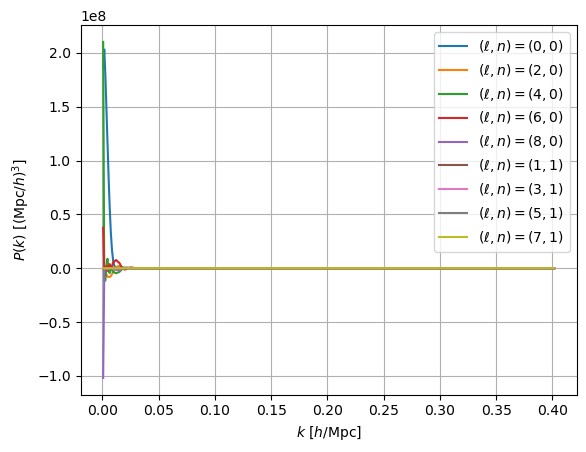

In [5]:
window2 = CatalogFFTWindowMultipole(randoms_positions1=randoms_positions, randoms_weights1=randoms_weights,
                                    power_ref=poles, edges=edges, boxsize=1000., position_type='pos', dtype='f4').poles
window = PowerSpectrumWindowMultipole.concatenate_x(window1, window2)

ax = plt.gca()
for iproj, proj in enumerate(window.projs):
    ax.plot(window.k, window(proj=proj, complex=False), label=proj.latex(inline=True))
ax.legend(loc=1)
ax.grid(True)
ax.set_xlabel('$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$P(k)$ [$(\mathrm{Mpc}/h)^{3}$]')
plt.show()
# Notice the increased k-range

## Configuration-space window

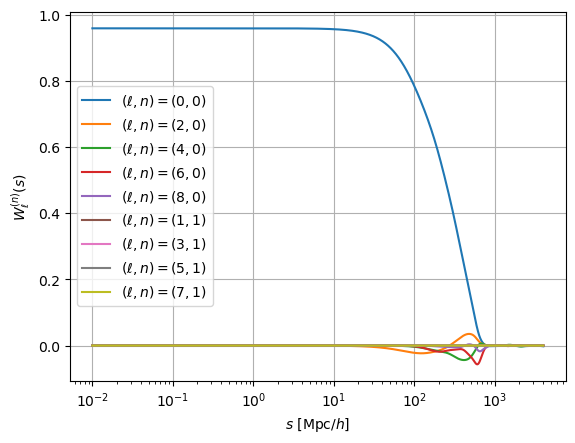

In [6]:
# Let us just take a look at the window function in configuration space
# Normalization is not quite 1 as s -> 0
# Small s is sensitive to Nyquist frequency,
# while convergence en large s is obtained with very large boxes
window_real = window.to_real(sep=np.geomspace(1e-2, 4e3, 2048))
ax = plt.gca()
for iproj, proj in enumerate(window_real.projs):
    ax.plot(window_real.sep, window_real(proj=proj), label=proj.latex(inline=True))
ax.legend()
ax.grid(True)
ax.set_xscale('log')
ax.set_xlabel('$s$ [$\mathrm{Mpc}/h$]')
ax.set_ylabel(r'$W_{\ell}^{(n)}(s)$')
plt.show()

In [7]:
# Let us compute the wide-angle and window function matrix
kout = np.linspace(0., 0.3, 120) # output k-bins
ellsin = [0, 2, 4] # input (theory) multipoles
wa_orders = 1 # wide-angle order
ellsout = [0, 2, 4] # output multipoles
sep = np.geomspace(1e-4, 4e3, 1024*16) # configuration space separation for FFTlog
kin_rebin = 2 # rebin input theory to save memory
kin_lim = (1e-3, 2e1) # pre-cut input (theory) ks to save some memory
# Input projections for window function matrix:
# theory multipoles at wa_order = 0, and wide-angle terms at wa_order = 1
projsinw = ellsin + PowerSpectrumOddWideAngleMatrix.propose_out(ellsin, wa_orders=wa_orders)
# Window matrix
wm = PowerSpectrumWindowMultipoleMatrix(kout, projsin=projsinw, projsout=ellsout, window=window, sep=sep, kin_rebin=kin_rebin, kin_lim=kin_lim)
# We resum over theory odd-wide angle
wawm = wm.copy()
wawm.resum_input_odd_wide_angle()
# Which is equivalent to lines below
# Wide-angle matrix: input projections are theory multipoles at wa_order = 0, return wide-angle terms at wa_order = 1
#wam = PowerSpectrumOddWideAngleMatrix(wm.xin[0], projsin=ellsin, projsout=wm.projsin, d=1., wa_orders=wa_orders, los=window.attrs['los_type'])
# Let us join wide-angle matrix and window function matrix
#wawm = BaseMatrix.join(wam, wm)
wm.select_proj(projsin=ellsin)

# You can save the matrix
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    wawm.save(fn)
    wawm = BaseMatrix.load(fn)
# If you change your mind and want to restrict input coordinates further:
kinlim = (1e-3, 1e1)
wawm.select_x(xinlim=kinlim)
print('Input theory limits are {}.'.format((wawm.xin[0].min(), wawm.xin[0].max())))
wm.select_x(xinlim=kinlim)
# You can also rebin e.g. output coordinates by 2, to obtain 120/2 = 60 k-bins
wawm.rebin_x(factorout=2)
print('There are {:d} output k-bins.'.format(len(wawm.xout[0])))
wm.rebin_x(factorout=2)

TypeError: __init__() got an unexpected keyword argument 'kinlim'

In [ ]:
kin = wawm.xin[0]
kout = wawm.xout[0]
# Some theory, just to illustrate the effect of the window function
from cosmoprimo import Cosmology
pklin = Cosmology().get_fourier('eisenstein_hu').pk_interpolator().to_1d()(kin)
def kaiser(f=0.8, bias=1.4):
    beta = f/bias
    toret = []
    toret.append((1. + 2./3.*beta + 1./5.*beta**2)*pklin)
    toret.append((4./3.*beta + 4./7.*beta**2)*pklin)
    toret.append(8./35*beta**2*pklin)
    return toret

pk = kaiser()
pkconv_wm = wm.dot(pk, unpack=True)
pkconv_wawm = wawm.dot(pk, unpack=True)
ax = plt.gca()
for ill in range(len(ellsout)):
    ax.plot(kin, kin*pk[ill], color='C{:d}'.format(ill), linestyle='--', label='theory' if ill == 0 else None)
    ax.plot(kout, kout*pkconv_wm[ill], color='C{:d}'.format(ill), linestyle=':', label='window' if ill == 0 else None)
    ax.plot(kout, kout*pkconv_wawm[ill], color='C{:d}'.format(ill), linestyle='-', label='window and wide-angle' if ill == 0 else None)
ax.set_xlim(0., 0.3)
ax.legend()
ax.set_xlabel('$k$ [$h/\mathrm{Mpc}$]')
ax.set_ylabel(r'$k P(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.show()

# More accurate computation
This amounts to computing the response of the power spectrum estimator to a change in theory (expanded onto some basis, here bandpower in $k$).
This follows Pat's derivations here:
- https://github.com/cosmodesi/GC_derivations

And some additional notes here:
- https://fr.overleaf.com/read/hpgbwqzmtcxn

In [ ]:
from pypower import CatalogFFTWindow, PowerSpectrumWindowMatrix

indexin1 = 400
edgesin1 = wawm.xin[0][indexin1:indexin1+2] # let us just focus on one bin, but you can provide as many as you wish
print('Input edges are {}.'.format(edgesin1))
# Remember, "poles" is the original power spectrum computation
fftwindow1 = CatalogFFTWindow(randoms_positions1=randoms_positions, randoms_weights1=randoms_weights, edgesin=edgesin1, power_ref=poles, position_type='pos').poles
# You can save the matrix
with tempfile.TemporaryDirectory() as tmp_dir:
    fn = os.path.join(tmp_dir, 'tmp.npy')
    fftwindow1.save(fn)
    fftwindow1 = PowerSpectrumWindowMatrix.load(fn)

In [ ]:
print('There are odd wide-angle theory poles: {}'.format(fftwindow1.projsin))
fftwindow_resumed = fftwindow1.copy()
fftwindow_resumed.resum_input_odd_wide_angle() # resum theory odd wide-angle
print('Removed after resummation: {}'.format(fftwindow_resumed.projsin))

In [ ]:
mapprox = wawm
maccurate = fftwindow_resumed
approx = mapprox.unpacked() # return block-matrix (list of list of matrices)
accurate = maccurate.unpacked()
fig,lax = plt.subplots(len(maccurate.projsout), len(maccurate.projsin), figsize=(15, 10))
for iin, projin in enumerate(maccurate.projsin):
    for iout, projout in enumerate(maccurate.projsout):
        # Indices in approximative window matrix
        iinapprox = mapprox.projsin.index(projin)
        ioutapprox = mapprox.projsout.index(projout)
        lax[iout][iin].plot(mapprox.xout[ioutapprox], approx[iinapprox][ioutapprox][indexin,:], label='approximate')
        lax[iout][iin].plot(maccurate.xout[iout], accurate[iin][iout][0,:], label='accurate')
        lax[iout][iin].set_title('${}$ x ${}$'.format(projin.latex(), projout.latex()))
        lax[iout][iin].legend()
plt.show()
# Differences between the approximate and accurate window function, at multipoles (2 and 4)
# may be due to the effect of incomplete (k, mu) sampling at low k in the approximate treatment.

## Parallelization
We have just computed the window matrix for one theory bin (we can do several at a time) - which takes some time already.
One can split the calculation of the full matrix by splitting the array of input (theory bins), and concatenate the
obtained matrices, as shown below.

In [ ]:
# You can do another the calculation, with other input (theory) bins
indexin2 = indexin + 1
edgesin2 = wawm.xin[0][indexin2:indexin2+2]
fftwindow2 = CatalogFFTWindow(randoms_positions1=randoms_positions, randoms_weights1=randoms_weights, edgesin=edgesin2, power_ref=poles, position_type='pos').poles
# Then concatenate with previous window
fftwindow = PowerSpectrumWindowMatrix.concatenate_x(fftwindow1, fftwindow2)
print('Input theory coordinates are now {}.'.format(fftwindow.xin[0]))
# Note: one can also split input projections "projsin", and do PowerSpectrumWindowMatrix.concatenate_proj

## Global (flat-sky limit) line-of-sight
Also implemented is the flat-sky limit line-of-sight.

In [ ]:
# Here we provide the (global) line-of-sight to override that of "poles", which is local (firstpoint)
# If the desired line-of-sight is the same as "poles", no need to provide it
fftwindow_flatsky = CatalogFFTWindow(randoms_positions1=randoms_positions, randoms_weights1=randoms_weights, edgesin=edgesin1, power_ref=poles, los='x', position_type='pos').poles

In [ ]:
# In this case, no wide-angle corrections are considered
print('Input (theory) projections are {}.'.format(fftwindow_flatsky.projsin))

In [ ]:
mapprox = fftwindow_flatsky
maccurate = fftwindow_resumed
approx = mapprox.unpacked() # return block-matrix (list of list of matrices)
accurate = maccurate.unpacked()
fig,lax = plt.subplots(len(mapprox.projsout), len(mapprox.projsin), figsize=(15, 10))
for iin, projin in enumerate(mapprox.projsin):
    for iout, projout in enumerate(mapprox.projsout):
        # Indices in approximative window matrix
        iinapprox = mapprox.projsin.index(projin)
        ioutapprox = mapprox.projsout.index(projout)
        lax[iout][iin].plot(mapprox.xout[ioutapprox], approx[iinapprox][ioutapprox][0,:], label='flat-sky')
        lax[iout][iin].plot(maccurate.xout[iout], accurate[iin][iout][0,:], label='first point')
        lax[iout][iin].set_title('${}$ x ${}$'.format(projin.latex(), projout.latex()))
        lax[iout][iin].legend()
plt.show()

## Periodic box
In case of periodic box, the window function accounts for the incomplete $(k, \mu)$ sampling at low $k$.

In [ ]:
# No need to provide any mesh
fftwindow_periodic = MeshFFTWindow(edgesin=edgesin, power_ref=poles, los='x', periodic=True)

In [ ]:
# In this case again, no wide-angle corrections are considered
print('Input (theory) projections are {}.'.format(fftwindow_periodic.projsin))

In [ ]:
mapprox = fftwindow_periodic
maccurate = fftwindow_flatsky
approx = mapprox.unpacked() # return block-matrix (list of list of matrices)
accurate = maccurate.unpacked()
fig,lax = plt.subplots(len(mapprox.projsout), len(mapprox.projsin), figsize=(15, 10))
for iin, projin in enumerate(mapprox.projsin):
    for iout, projout in enumerate(mapprox.projsout):
        # Indices in approximative window matrix
        iinapprox = mapprox.projsin.index(projin)
        ioutapprox = mapprox.projsout.index(projout)
        lax[iout][iin].plot(mapprox.xout[ioutapprox], approx[iinapprox][ioutapprox][0,:], label='periodic')
        lax[iout][iin].plot(maccurate.xout[iout], accurate[iin][iout][0,:], label='flat-sky')
        lax[iout][iin].set_title('${}$ x ${}$'.format(projin.latex(), projout.latex()))
        lax[iout][iin].legend()
plt.show()

## $k$-rebinning
We provide methods to rebin power spectrum and window estimation accurately, i.e. taking the number of $k$-modes into account.

In [ ]:
# Let us say one compute the power spectrum with fine k-bins, and one wants to rebin that measurement
poles.rebin(2)
# One can do the same for the window
fftwindow_resumed.rebin_x(factorout=2)